# Pytorch

In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as T
from torchvision.datasets import CIFAR10
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader

In [ ]:
dataset = CIFAR10(root = "data/", download = True, transform = T.ToTensor())

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/


In [ ]:
len(dataset)

50000

In [ ]:
def show_image(img, label):
  plt.imshow(img.permute(1, 2, 0))
  plt.axis(False)
  plt.title(dataset.classes[label])
  print(f"      Size: {img.numpy().shape}")

      Size: (3, 32, 32)


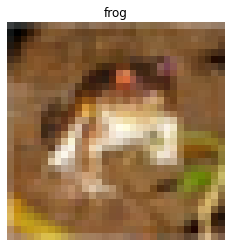

In [ ]:
show_image(*dataset[0])

In [ ]:
train_size = int(len(dataset)*0.8)
val_size = int(len(dataset)*0.2)
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(40000, 10000)

      Size: (3, 32, 32)


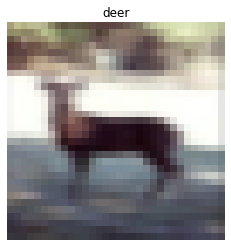

In [ ]:
show_image(*train_ds[0])

      Size: (3, 32, 32)


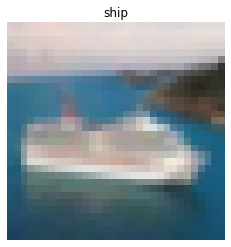

In [ ]:
show_image(*val_ds[0])

In [ ]:
BATCH_SIZE = 128

train_dl = DataLoader(train_ds, shuffle = True, pin_memory = True,
                      num_workers = 2, batch_size = BATCH_SIZE)

val_dl = DataLoader(val_ds, batch_size = BATCH_SIZE, pin_memory = True, num_workers = 2)

In [ ]:
len(train_dl), len(val_dl)

(313, 79)

In [ ]:
for images, labels in train_dl:
  print(images.shape, "\n", labels.shape)
  print(labels)
  break

torch.Size([128, 3, 32, 32]) 
 torch.Size([128])
tensor([5, 4, 4, 8, 2, 0, 0, 2, 2, 7, 3, 6, 5, 9, 7, 0, 1, 9, 1, 8, 0, 7, 3, 0,
        0, 8, 8, 3, 7, 1, 4, 2, 8, 9, 7, 1, 5, 7, 3, 8, 1, 4, 6, 6, 1, 8, 5, 8,
        7, 1, 5, 7, 2, 9, 0, 3, 1, 3, 2, 5, 7, 5, 3, 4, 2, 0, 3, 1, 8, 5, 9, 1,
        3, 3, 1, 9, 6, 2, 3, 9, 8, 6, 2, 2, 3, 9, 9, 9, 4, 0, 4, 5, 9, 6, 9, 2,
        5, 0, 3, 7, 1, 9, 0, 9, 0, 1, 1, 7, 5, 5, 2, 3, 3, 4, 7, 9, 3, 9, 6, 6,
        0, 9, 5, 0, 5, 3, 4, 4])


In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


def CNN_Block(in_channels, out_channels):

      block = []

      block.append(nn.Conv2d(in_channels, out_channels, 3, 1, 1))
      block.append(nn.ReLU())
      block.append(nn.AvgPool2d(2))
      block.append(nn.BatchNorm2d(out_channels))

      return block

class CifarModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_channels, num_classes):
        super().__init__()

        sequential = []
        sequential += CNN_Block(3, 16)
        sequential += CNN_Block(16, 32)
        sequential += CNN_Block(32, 64)
        sequential += CNN_Block(64, 128)
        sequential += CNN_Block(128, 256)
        sequential.append(nn.Flatten())
        sequential.append(nn.Linear(256, 10))
        sequential.append(nn.Dropout(0.2))
        sequential.append(nn.Softmax())

        self.model = nn.Sequential(*sequential)
        
    def forward(self, xb):
        # Pass the input through the model
        return self.model(xb)
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [ ]:
in_channels = 3
num_classes = len(dataset.classes)

model = CifarModel(in_channels, num_classes)

In [ ]:
model

CifarModel(
  (model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (15): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (16): Conv2d(1

In [ ]:
for images, labels in train_dl:
  print("Images shape", images.shape)
  outputs = model(images)
  print("Output shape", outputs.shape)
  print("out[0]:", outputs[0])
  print("Sum of probabilities", torch.sum(outputs[0]))
  break

Images shape torch.Size([128, 3, 32, 32])
Output shape torch.Size([128, 10])
out[0]: tensor([0.1230, 0.0550, 0.0932, 0.0395, 0.0354, 0.0809, 0.1635, 0.1636, 0.1230,
        0.1230], grad_fn=<SelectBackward0>)
Sum of probabilities tensor(1., grad_fn=<SumBackward0>)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [ ]:
torch.cuda.is_available()

True

In [ ]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device("cuda")
  return torch.device("cpu")

def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking = True)

class DeviceDataLoader():

  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
val_dl = DeviceDataLoader(val_dl, device)
train_dl = DeviceDataLoader(train_dl, device)
to_device(model, device)

CifarModel(
  (model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (15): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (16): Conv2d(1

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
  model.eval()
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
  history = []
  optimizer = opt_func(model.parameters(), lr = lr)
  for epoch in range(epochs):

    # Training phase
    model.train()
    train_losses = []
    for batch in train_loader:
      loss = model.training_step(batch)
      train_losses.append(loss)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    # Validation phase
    result = evaluate(model, val_loader)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    model.epoch_end(epoch, result)
    history.append(result)
    
  return history

In [ ]:
model = to_device(CifarModel(in_channels, num_classes), device)

In [ ]:
evaluate(model, val_dl)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


{'val_acc': 0.09711234271526337, 'val_loss': 2.3026583194732666}

In [ ]:
num_epochs = 30
lr = 0.001
opt_func = torch.optim.Adam

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch [0], val_loss: 1.9824, val_acc: 0.4799
Epoch [1], val_loss: 1.9169, val_acc: 0.5431
Epoch [2], val_loss: 1.8910, val_acc: 0.5722
Epoch [3], val_loss: 1.8394, val_acc: 0.6262
Epoch [4], val_loss: 1.8284, val_acc: 0.6319
Epoch [5], val_loss: 1.7940, val_acc: 0.6682
Epoch [6], val_loss: 1.9034, val_acc: 0.5544
Epoch [7], val_loss: 1.7631, val_acc: 0.7012
Epoch [8], val_loss: 1.7461, val_acc: 0.7159
Epoch [9], val_loss: 1.7472, val_acc: 0.7147
Epoch [10], val_loss: 1.7451, val_acc: 0.7161
Epoch [11], val_loss: 1.7370, val_acc: 0.7248
Epoch [12], val_loss: 1.7475, val_acc: 0.7151
Epoch [13], val_loss: 1.7364, val_acc: 0.7251
Epoch [14], val_loss: 1.7362, val_acc: 0.7244
Epoch [15], val_loss: 1.7881, val_acc: 0.6701
Epoch [16], val_loss: 1.7099, val_acc: 0.7501
Epoch [17], val_loss: 1.7192, val_acc: 0.7416
Epoch [18], val_loss: 1.7363, val_acc: 0.7237
Epoch [19], val_loss: 1.7167, val_acc: 0.7452
Epoch [20], val_loss: 1.7156, val_acc: 0.7445
Epoch [21], val_loss: 1.6993, val_acc: 0.760

Text(0.5, 0, 'Epochs')

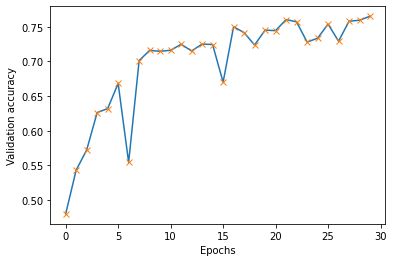

In [ ]:
accuracies = [x["val_acc"] for x in history]
plt.plot(accuracies)
plt.plot(accuracies, "x")
plt.ylabel("Validation accuracy")
plt.xlabel("Epochs")

Text(0.5, 1.0, 'Training and Validation Losses vs Epochs')

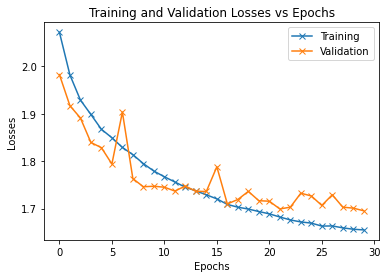

In [ ]:
train_loss = [x["train_loss"] for x in history]
val_loss = [x["val_loss"] for x in history]
plt.plot(train_loss, "-x")
plt.plot(val_loss, "-x")
plt.ylabel("Losses")
plt.xlabel("Epochs")
plt.legend(["Training", "Validation"])
plt.title("Training and Validation Losses vs Epochs")

## Augmentation

In [ ]:
import torch
import tarfile
import os
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as T
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader

We can't use the torchvision.datasets.CIFAR10 here because when we augment the dataset the whole data becomes augmneted. And that means that also the validation data will be augmented. Which is not what we want, since in the real world data will not be augmented.


So instead we will download the dataset from a URL.

In [ ]:
URL = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(URL, ".")

  0%|          | 0/135107811 [00:00<?, ?it/s]

In [ ]:
# Extract the file
with tarfile.open("/content/cifar10.tgz", "r:gz") as tar:
  tar.extractall(path = "./data")

In [ ]:
data_dir = "/content/data/cifar10"

os.listdir(data_dir)

['train', 'test']

In [ ]:
train_dir = data_dir + "/train"
val_dir = data_dir + "/test"

os.listdir(train_dir)

['truck',
 'airplane',
 'horse',
 'bird',
 'ship',
 'dog',
 'frog',
 'deer',
 'cat',
 'automobile']

In [ ]:
len(os.listdir(train_dir + "/bird")), len(os.listdir(val_dir + "/bird"))

(5000, 1000)

In [ ]:
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

train_tfms =  T.Compose([
                         
                T.RandomHorizontalFlip(0.5),
                T.RandomCrop(32, padding = 4, padding_mode = "reflect"),
                T.ToTensor(),
                T.Normalize(*stats, inplace = True)

              ])

valid_tfms = T.Compose([
                        
                T.ToTensor(),
                T.Normalize(*stats)
                
              ])

In [ ]:
train_ds = ImageFolder(train_dir, transform = train_tfms)
val_ds = ImageFolder(val_dir, transform = valid_tfms)

In [ ]:
len(train_ds), len(val_ds)

(50000, 10000)

In [ ]:
# Create DataLoaders

batch_size = 128

train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 2, pin_memory = True)
valid_dl = DataLoader(val_ds, batch_size, num_workers = 2, pin_memory = True)

In [ ]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device("cuda")
  return torch.device("cpu")

def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking = True)

class DeviceDataLoader():

  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


def CNN_Block(in_channels, out_channels):

      block = []

      block.append(nn.Conv2d(in_channels, out_channels, 3, 1, 1))
      block.append(nn.ReLU())
      block.append(nn.AvgPool2d(2))
      block.append(nn.BatchNorm2d(out_channels))

      return block

class CifarModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_channels, num_classes):
        super().__init__()

        sequential = []
        sequential += CNN_Block(3, 16)
        sequential += CNN_Block(16, 32)
        sequential += CNN_Block(32, 64)
        sequential += CNN_Block(64, 128)
        sequential += CNN_Block(128, 256)
        sequential.append(nn.Flatten())
        sequential.append(nn.Linear(256, 10))
        sequential.append(nn.Dropout(0.2))
        sequential.append(nn.Softmax())

        self.model = nn.Sequential(*sequential)
        
    def forward(self, xb):
        # Pass the input through the model
        return self.model(xb)
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [ ]:
in_channels = 3
num_classes = len(train_ds.classes)

model = CifarModel(in_channels, num_classes)

In [ ]:
model

CifarModel(
  (model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (15): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (16): Conv2d(1

In [ ]:
model = to_device(CifarModel(in_channels, num_classes), device)
model

CifarModel(
  (model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (15): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (16): Conv2d(1

In [ ]:
for images, labels in train_dl:
  print("Images shape", images.shape)
  outputs = model(images)
  print("Output shape", outputs.shape)
  print("out[0]:", outputs[0])
  print("Sum of probabilities", torch.sum(outputs[0]))
  break

Images shape torch.Size([128, 3, 32, 32])
Output shape torch.Size([128, 10])
out[0]: tensor([0.1691, 0.1019, 0.1792, 0.1418, 0.0396, 0.0855, 0.1271, 0.0401, 0.0485,
        0.0672], device='cuda:0', grad_fn=<SelectBackward0>)
Sum of probabilities tensor(1.0000, device='cuda:0', grad_fn=<SumBackward0>)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
  model.eval()
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
  history = []
  optimizer = opt_func(model.parameters(), lr = lr)
  for epoch in range(epochs):

    # Training phase
    model.train()
    train_losses = []
    for batch in train_loader:
      loss = model.training_step(batch)
      train_losses.append(loss)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    # Validation phase
    result = evaluate(model, val_loader)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    model.epoch_end(epoch, result)
    history.append(result)
    
  return history

In [ ]:
evaluate(model, valid_dl)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


{'val_acc': 0.0995846539735794, 'val_loss': 2.3026161193847656}

In [ ]:
num_epochs = 30
lr = 0.001
opt_func = torch.optim.Adam

history = fit(num_epochs, lr, model, train_dl, valid_dl, opt_func)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch [0], val_loss: 1.9430, val_acc: 0.5192
Epoch [1], val_loss: 1.8681, val_acc: 0.5935
Epoch [2], val_loss: 1.8384, val_acc: 0.6233
Epoch [3], val_loss: 1.8169, val_acc: 0.6458
Epoch [4], val_loss: 1.8159, val_acc: 0.6454
Epoch [5], val_loss: 1.7931, val_acc: 0.6690
Epoch [6], val_loss: 1.7768, val_acc: 0.6835
Epoch [7], val_loss: 1.7626, val_acc: 0.6976
Epoch [8], val_loss: 1.7655, val_acc: 0.6946
Epoch [9], val_loss: 1.7395, val_acc: 0.7206
Epoch [10], val_loss: 1.7464, val_acc: 0.7134
Epoch [11], val_loss: 1.7295, val_acc: 0.7327
Epoch [12], val_loss: 1.7302, val_acc: 0.7304
Epoch [13], val_loss: 1.7292, val_acc: 0.7323
Epoch [14], val_loss: 1.7290, val_acc: 0.7319
Epoch [15], val_loss: 1.7165, val_acc: 0.7426
Epoch [16], val_loss: 1.7265, val_acc: 0.7335
Epoch [17], val_loss: 1.7102, val_acc: 0.7500
Epoch [18], val_loss: 1.7152, val_acc: 0.7432
Epoch [19], val_loss: 1.7193, val_acc: 0.7422
Epoch [20], val_loss: 1.6989, val_acc: 0.7618
Epoch [21], val_loss: 1.6929, val_acc: 0.767

Text(0.5, 0, 'Epochs')

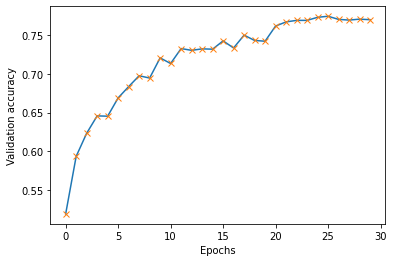

In [ ]:
val_acc = [x["val_acc"] for x in history]
plt.plot(accuracies)
plt.plot(accuracies, "x")
plt.ylabel("Validation accuracy")
plt.xlabel("Epochs")

Text(0.5, 1.0, 'Training and Validation Losses vs Epochs')

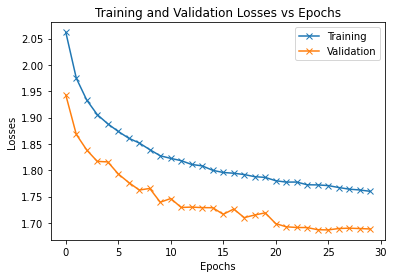

In [ ]:
train_loss = [x["train_loss"] for x in history]
val_loss = [x["val_loss"] for x in history]
plt.plot(train_loss, "-x")
plt.plot(val_loss, "-x")
plt.ylabel("Losses")
plt.xlabel("Epochs")
plt.legend(["Training", "Validation"])
plt.title("Training and Validation Losses vs Epochs")

## Different model

In [ ]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim = 1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
  def training_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    return loss

  def validation_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    acc = accuracy(out, labels)
    return {"val_loss" : loss.detach(), "val_acc" : acc}

  def validation_epoch_end(self, outputs):
    losses = [x["val_loss"] for x in outputs]
    epoch_loss = torch.stack(losses).mean()
    accuracies = [x["val_acc"] for x in outputs]
    epoch_acc = torch.stack(accuracies).mean()
    return {"val_loss" : epoch_loss.item(), "val_acc" : epoch_acc.item()}

  def epoch_end(self, epoch, result):
    print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
def conv_block(in_channels, out_channels, pool = False):
  layers = [nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace = True)]

  if pool:
    layers.append(nn.MaxPool2d(2))

  return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
  def __init__(self, in_channels, num_classes):
    super().__init__()

    self.conv1 = conv_block(in_channels, 64)
    self.conv2 = conv_block(64, 128, pool = True)
    self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

    self.conv3 = conv_block(128, 256, pool = True)
    self.conv4 = conv_block(256, 512, pool = True)    
    self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

    self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                    nn.Flatten(),
                                    nn.Dropout(0.2),
                                    nn.Linear(512, num_classes))
    
  def forward(self, xb):
    out = self.conv1(xb)
    out = self.conv2(out)
    out = self.res1(out) + out
    out = self.conv3(out)
    out = self.conv4(out)
    out = self.res2(out)
    return self.classifier(out)

In [ ]:
model = to_device(ResNet9(in_channels, num_classes), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
  model.eval()
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
  
  torch.cuda.empty_cache()
  history = []

  # Set up custom optimizer with weight decay
  optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
  # Set up one-cycle learning rate scheduler
  sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                              steps_per_epoch=len(train_loader))

  for epoch in range(epochs):
    # Training phase
    model.train()
    train_losses = []
    lrs = []
    for batch in train_loader:
      loss = model.training_step(batch) 
      train_losses.append(loss)
      loss.backward()

      # Gradient clipping
      if grad_clip is not None:
        nn.utils.clip_grad_value_(model.parameters(), grad_clip)

      optimizer.step()
      optimizer.zero_grad()

      # Record & update learning rate
      lrs.append(get_lr(optimizer))
      sched.step()

    # Validation phase
    result = evaluate(model, val_loader)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    result['lrs'] = lrs
    model.epoch_end(epoch, result)
    history.append(result)

  return history

In [ ]:
history = [evaluate(model, valid_dl)]
history

[{'val_acc': 0.09859573096036911, 'val_loss': 2.3028481006622314}]

In [ ]:
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history = fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl,
                        weight_decay, grad_clip, opt_func)

Epoch [0], last_lr: 0.00395, train_loss: 1.3424, val_loss: 1.4069, val_acc: 0.5632
Epoch [1], last_lr: 0.00936, train_loss: 0.9501, val_loss: 0.9614, val_acc: 0.6546
Epoch [2], last_lr: 0.00972, train_loss: 0.7799, val_loss: 1.3136, val_acc: 0.5691
Epoch [3], last_lr: 0.00812, train_loss: 0.6976, val_loss: 1.0890, val_acc: 0.6486
Epoch [4], last_lr: 0.00556, train_loss: 0.6241, val_loss: 0.7403, val_acc: 0.7544
Epoch [5], last_lr: 0.00283, train_loss: 0.5189, val_loss: 0.4816, val_acc: 0.8354
Epoch [6], last_lr: 0.00077, train_loss: 0.3786, val_loss: 0.3537, val_acc: 0.8793
Epoch [7], last_lr: 0.00000, train_loss: 0.2538, val_loss: 0.2957, val_acc: 0.9017
CPU times: user 1min 5s, sys: 4.5 s, total: 1min 10s
Wall time: 4min 41s


In [ ]:
def plot_accuracies(history):
  accuracies = [x["val_acc"] for x in history]
  plt.plot(accuracies, '-x')
  plt.xlabel("epoch")
  plt.ylabel("accuracy")
  plt.title("Accuracy vs. No. of epochs")

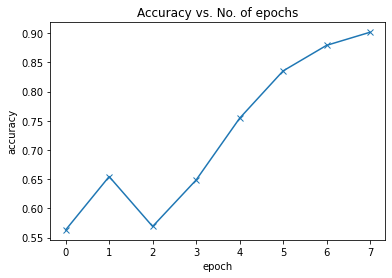

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

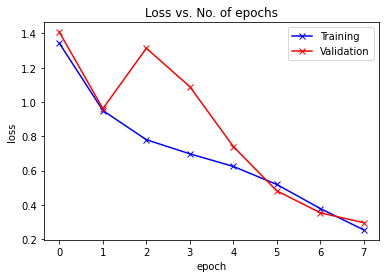

In [ ]:
plot_losses(history)

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

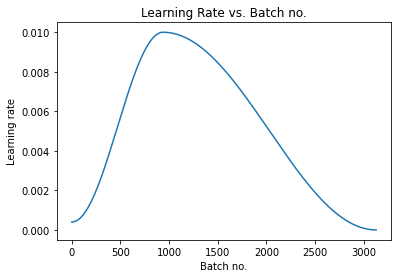

In [ ]:
plot_lrs(history)